# Using a Seasonal ARIMA Model to Predict ISP Revenue.

Max Sydow, WGU, D213 Task1 Performance Assessment

### Purpose

At a very high level, the upper-most tiers of leadership including the board of directors of an ISP may be interested in a quick summary of overall revenue trends.  Seasonal fluctuations and possible predictions for future time periods should be available for such a broad measure after the first 2 years of operations.   

An analyst or data scientist may begin their approach to such an insight driven task by asking themselves if there exists any periodic repetetiveness over time for overall revenue.  During the first 2 years of operations is there a significant difference in the revenenue for Q2 from the other quarters or seasons?  Perhaps a more interesting report would say whether revenue is expected to increase in future months.  Crucial decisions regarding investor engagement and top-down reorganization of the company may impinge upon these results.

## Method Justification

In addition to periodic fluctuation in revenue over time there may exist larger upward or downward trends over the 2 year span of available data.  A smoothed out pattern of mean revenue could be plotted to help visualize this if that were the case.  On the other hand, too much fluctuation on a smaller scale may indicate noise which could impeede efforts to make predictions.  A machine learning model may place too much emphasis on this noise and result in overfitting on test data.  A transformation to mitigate larger trends can ensure stationarity of time series data, while spectral decomposition can aid with reducing random noise.  All these factors should be considered when building a predictive time series model.

Autocorrelation takes samples of times series data over the same time intervals and measures strength of correlation between them.  An example of a single lag could be correlating one month of data with the previous month.  When more previous months, or any lengths of time period are correlated the lag count increments by 1 for each successive interval.  With more lag intervals there are more possibilities of interactions amongst sub-intervals, and autocorellation treats all of these.  Partial autocorellation looks only at interactions between adjacent lags.  (Abhishek, 2019)    An Auto Regressive (AR) model uses partial auto-correlation, and yields an equation of the form:

Y(t) = B1 + M1Y(t-1) + M2Y(t-2) + ... + MpY(t-p),

where p is the lag order in the time series, and the Ms are the weights of lagged observations.

Moving Average (MA) treats errors in the lagged observations from AR.  The resulting equation is of the same form as the one derived from partial autocorrelation.

Yt = B2 + w1E(t-1) + w2E(t-2) + ... + wqE(t-q) + Et.

Here the w's are weights of the error terms E, and q is the size of the moving window.

When AR and MA are combined the equations is:

Yt = (B1 + B2) + (M1Y(t-1) + ... + MpY(t-p)) 
               + (w1E(t-1) + w2E(t-2) + ... + wqE(t-q) + Et)


Another important feature of a time series to consider is the behavior of means and standard deviations within lagged intervals.  One way that means may differ is if there are seasonal trends in the data.  While the means within fall and winter months may not differ too much, the larger fall and winter means might.  This indicates seasonality within the time series.  Distributions amongnst intervals may also exist, which would indicate the MA error term is not constant.  For a time series to be stationary the means and standard deviations of lagged samples need to be constant, and there should be no seasonality.

An Integrated ARMA (ARIMA) model mitigates moving means.  This can be accomplished by taking the difference of successive lagged intervals, or perhaps using a log or other form of transform.  Before ensuring the stationarity assumption and performing any transformation, it is imperitive to check for any missing values and deal with outliers.

## Data Preparation

First, the csv containing 2 years of daily revenue is read into a dataframa.  Then some brief inspections are performed.

In [1]:
import pandas as pd
telco = pd.read_csv('C:/Users/maxgs/MSDA/D213/teleco_time_series .csv', header=0, index_col=0)

In [2]:
telco.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


In [3]:
print(telco.dtypes)

Revenue    float64
dtype: object


In [4]:
telco.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [5]:
telco.isnull().sum()

Revenue    0
dtype: int64

The time variable, Day, is already set as the index for the telco dataframe so that ensures no missing time values.  There are no missing values in the Revenue column.  There are 731 rows, which implies that one of the years is a leap year.  The values for the index appear to be integers, which will create problems with code later on.  The actual dates for this series were not specified, but 2020 was a leap year, so without harming any functionality of the analysis the 2 year window can be re-indexed to begin on Jan 1, 2020 and end on Dec 31, 2021.   

In [6]:
# create a DatetimeIndex corresponding to the integers in existing index
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import datetime
### d_range = pd.date_range("2020-01-01", "2021-12-31")
day_range = pd.date_range("2020-01-01", periods=731, freq="D")
telco2 = telco
telco2['date'] = day_range

In [7]:
telco2.head(5)

,Revenue,date
Day,,
1,0.000000,2020-01-01
2,0.000793,2020-01-02
3,0.825542,2020-01-03
4,0.320332,2020-01-04
5,1.082554,2020-01-05


In [8]:
# replace old integer index with new date index 

telco2 = telco2.set_index('date', 1)
telco2.head(5)

,Revenue
date,
2020-01-01,0.000000
2020-01-02,0.000793
2020-01-03,0.825542
2020-01-04,0.320332
2020-01-05,1.082554


### Initial Visualization and stationarity

Now a plot of the time series can be made.  Stationarity of the series can be examined through an augmented Dickey-Fuller test, which allows rejecting or accepting a null hypothesis that a time series is non-stationary due to trend.  When the p-value < 0.05 the null hypothesis can be rejected.  This is criterion is included in the 'test_stationarity' function below by specifying series elements in the adfuller method from the statsmodels.tsa.stattools package.  The code for this function was adapted from Sun's Kaggle notebook.

In [9]:
import matplotlib.pyplot as plt

ax = telco2.plot()
ax.set_xlabel('date')
ax.set_ylabel('Revenue')
plt.show()

<Figure size 640x480 with 1 Axes>

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(telco2, window = 12, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = telco2.rolling(window).mean()
    rolstd = telco2.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(telco2, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
#Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(telco2, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)    

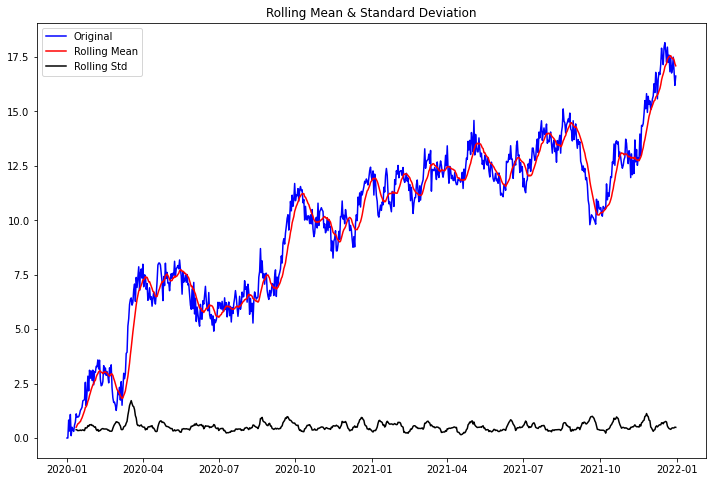

Results of Dickey-Fuller Test:
p-value = 0.3206. The series is likely non-stationary.
Test Statistic                  -1.924612
p-value                          0.320573
#Lags Used                       1.000000
Number of Observations Used    729.000000
Critical Value (1%)             -3.439352
Critical Value (5%)             -2.865513
Critical Value (10%)            -2.568886
dtype: float64


In [11]:
test_stationarity(telco2, window = 12, cutoff = 0.01)

Aside from there being a clear upward trend in the plot, the Dickey-Fuller test indicates non-stationarity.  The difference of each value the previous in the series can transform it so that it becomes stationary.

In [12]:
telco_stationary = telco2.diff().dropna()

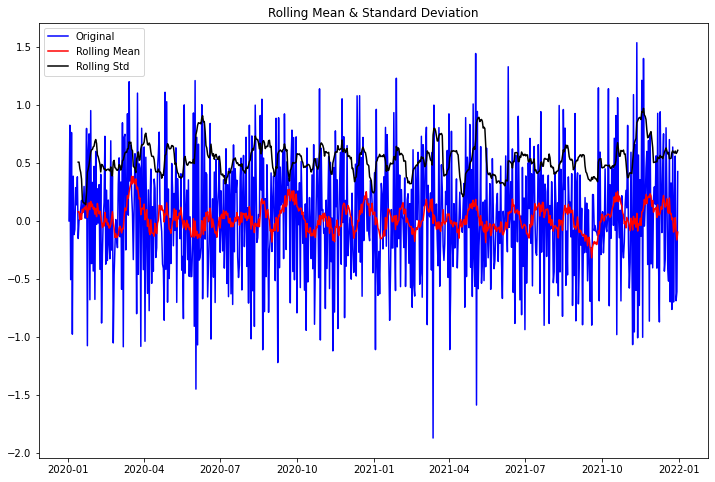

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                 -44.874527
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    729.000000
Critical Value (1%)             -3.439352
Critical Value (5%)             -2.865513
Critical Value (10%)            -2.568886
dtype: float64


In [13]:
test_stationarity(telco_stationary, window = 12, cutoff = 0.01)

The test indicates the series is now stationary.  This can be seen in the above plot for rolling mean and standard deviation as well.  

#### Train-test split.

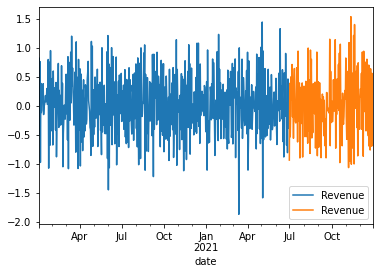

In [14]:
# Split the stationary data into a train and test set 
# using the first 1.5 years (75%) for training

telco_stat_train = telco_stationary.loc[:'2021-06-30']
telco_stat_test = telco_stationary.loc['2021-07-01':]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
telco_stat_train.plot(ax=ax)
telco_stat_test.plot(ax=ax)
plt.show()

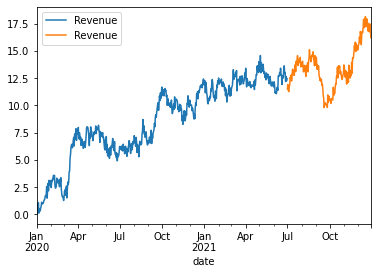

In [15]:
# Split the original data into a train and test set 
# using the first 1.5 years (75%) for training

telco_train = telco2.loc[:'2021-06-30']
telco_test = telco2.loc['2021-07-01':]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
telco_train.plot(ax=ax)
telco_test.plot(ax=ax)
plt.show()

In [43]:
# save training and testing sets
telco_train.to_excel('C:/Users/maxgs/MSDA/D213/telco_train.xlsx')
telco_test.to_excel('C:/Users/maxgs/MSDA/D213/telco_test.xlsx')

## Model Identification and Analysis

### Decomposition
The statsmodels.api package allows a time series to be decomposed to show trend and seasonal components, as well as a residual plot of noise.  (DataCamp)  The below plots show the decompositions for both initial and stationary time series.

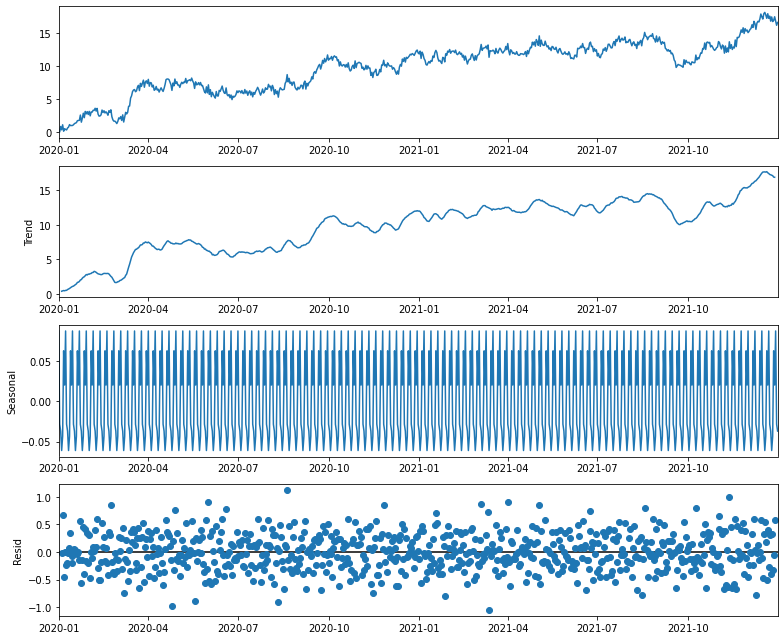

In [16]:
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(
    telco2)

fig = decomposition.plot()
plt.show()


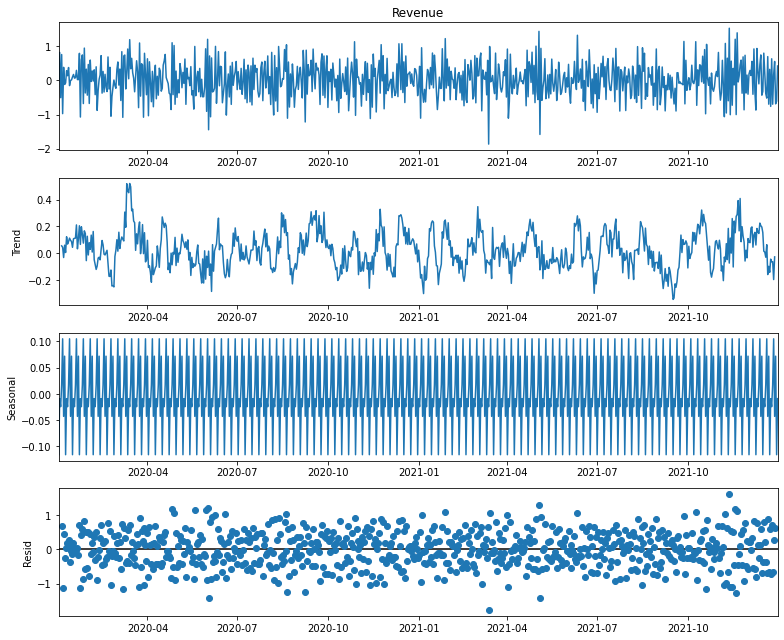

In [17]:
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(telco_stationary['Revenue'], 
                            period=7)

# Plot decomposition
decomp.plot()
plt.show()

In the above decomposition of the original time series, there does appear to be an upward trend over the 2 year span.  13 cycles can be counted on the seasonal plot between 2020-01 and 2020-04.  There are 91 days in the first 3 months of 2020, so when divided by the number of cycles it turns out that each period is 7 days long.  In other words, there is a weekly seasonal pattern in this data.  The symmetric distribution of the residual plot indicates lack of outliers.  The adapted code and meaning of the decomposition was discussed in chapter 3 of the Visualizing Time Series DataCamp course.

Decomposing the stationary time series reveals a lack of trend more clearly, and the observations regarding seasonality and residual distributions still hold.

A power sprectral density plot can be made, which indicates strength of variation in the time series by frequency.  The plot is based on Fast Fourier Transform (FFT), which uses integration to pick out periods of most significant fluctuation.  Welch's method performs this transform by making estimates on overlapping segments of the data. (The Scipy community).  Matplotlib allows easy visualization of the plot. (Scipy Lecture Notes).  The higher power at lower frequency indicates greater fluctuation in Revenue for smaller time periods.

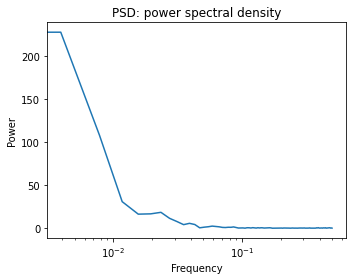

In [18]:
from scipy import signal

freqs, psd = signal.welch(telco2['Revenue'])

plt.figure(figsize=(5, 4))
plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

A periodogram is a sample estimate of the spectral density and indicates relative strengths of frequencies that explain variation in a time series.  (PennState 2022).  It is directly related to autocovariance in the time-domain.  Autocovariance can be thought of as the product of autocorrelation and variance.  This product has a couple of low reaching peaks at lower frequencies, which if due to low variance, may indicate more observability of repetition of the frequencies.

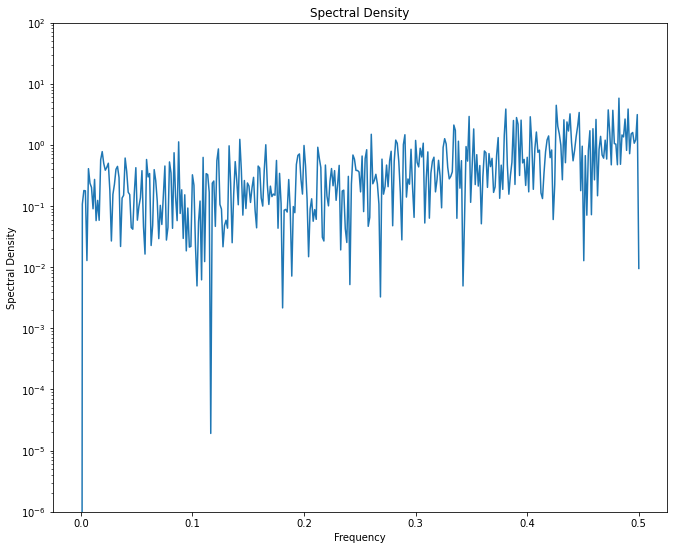

In [19]:
f, Pxx_den = signal.periodogram(telco_stationary['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

### Autocorrelation

Autocorrelation and partial autocorrelation plots for the stationary time series can be made for weekly periods by specifying the lags parameter.  There are 104 weeks in the 2 year span of data.  The above PSD agrees with the periodicity shown in the plots below in that most of the variation occurs at a frequency of about 1/100.

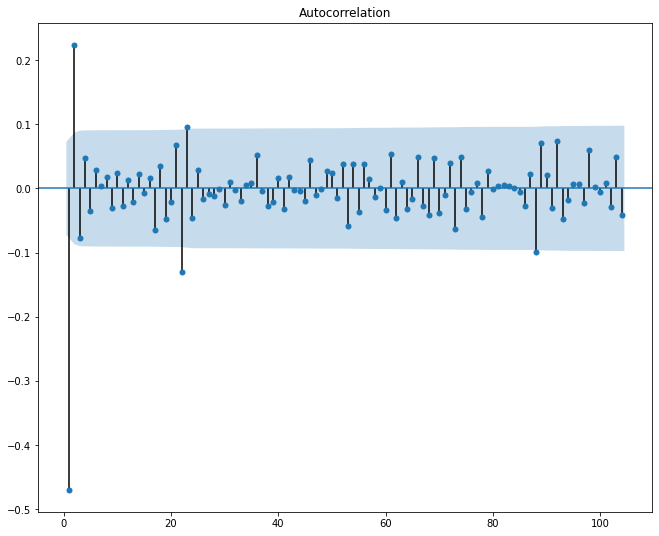

In [20]:
from statsmodels.graphics import tsaplots

# partial autocorrelation plot with 104 lags - 1 for each week
fig = tsaplots.plot_acf(telco_stationary['Revenue'], lags=104, zero=False)

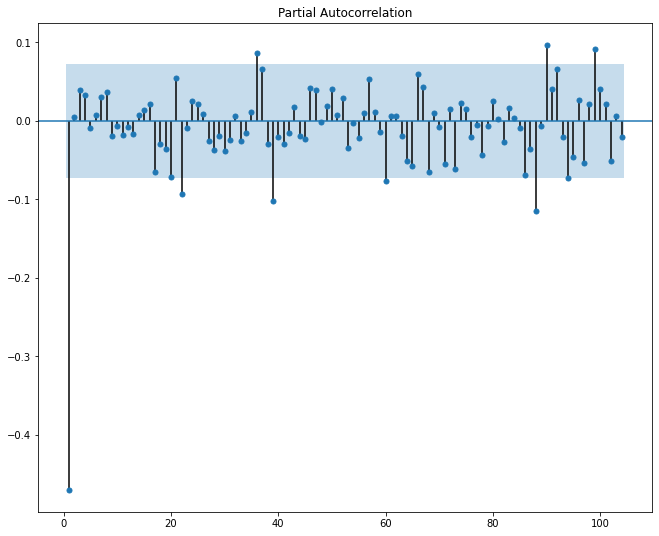

In [21]:
fig = tsaplots.plot_pacf(telco_stationary['Revenue'], lags=104, zero=False)

The above plots show a moderate negative correlation with an R around 0.5 for the most recent past weekly period.  Some weaker positive and negative correlations appear for other intervals, especially in the ACF within lag interactions, but most are barely outside the 0.05 significance threshold.  In other words there is some negative weekly correlation within the time series.

An ARMA model could be applied to the stationary time series, but in order to do any forcasting the cumulative sum needs to be computed as the model will make predictions on the difference.  An ARIMA model takes care of this integration of the differences.  The statsmodels generalized ARIMA model is SARIMAX, which has the ability to incorporate seasonal variation  and an exogeneous, or external variable.  This is where the 'S' and 'X' are added into the model name.  The three paramaters are:

p - number of autoregressive lags

d - order of differencing

q - number of moving average lags.

Since the series was made stationary by differencing once, d=1.

The ACF and PACF can be used to choose model order.  When the ACF tails off and the PACF cuts off after a lag p then p is the AR parameter.  If the ACF cuts off after a lag q, and the PACF tails off then an MA(q) model can be applied.  If both correlation functions tail off then p and q aren't as easy to determine in an ARMA(p,q) model. The appearance of several weak correlations in the above ACF and PACF plots look like they both tail off.  However, one might intepret the ACF plot as cutting off after q=2, and the PACF cutting off after p=1.  Using this logic to determine p and q seems a bit murky, but there is a better way.

The Akaike information criterion (AIC), and Bayesian information criterion (BIC) can both be used to determine optimal orders of the AR and MA components of an ARIMA model.  Both criteria favor lower values, but AIC is better at choosing on prediction accuracy while BIC favors model simplicity.  The code below prints both metrics in ascending order for a range of p's and q's for a model created for the stationary training data.  

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# An ARMA(p,q) + constant modelmodel = SARIMAX(df, order=(p,0,q), trend='c')
import warnings
warnings.filterwarnings("ignore")


# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(2):
  # Loop over q values from 0-2
    for q in range(2):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(telco_stat_train, order=(p,1,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))


   p  q          AIC          BIC
3  1  1   733.972496   746.874853
1  0  1   865.305301   873.906873
2  1  0  1022.585669  1031.187241
0  0  0  1443.708610  1448.009395
   p  q          AIC          BIC
3  1  1   733.972496   746.874853
1  0  1   865.305301   873.906873
2  1  0  1022.585669  1031.187241
0  0  0  1443.708610  1448.009395


It looks like both metrics favor p=1, q=1, so there is no need to worry  about weighing accuracy versus simplicity.

### Model Evaluation

Four diagnostic plots of residuals can be made from the fitted model.  Ideally the standardized residual plot should have no pattern or trend.  The histogram plus estimated density plot contains a smoothed histogram curve (KDE) and a normal Gaussian distribution (N(0,1)).  The KDE and normal distributions should match closely and almost overlap indicating that the residuals are random and indistinguishable from noise.  Most points, except for some at either end of the normal Q-Q plot should lie along the diagonal line.  The Correlogram is an ACF of residuals, and 95% of correlations should not be significant.  The 4 plots for the fitted model adhere to these expectations.  

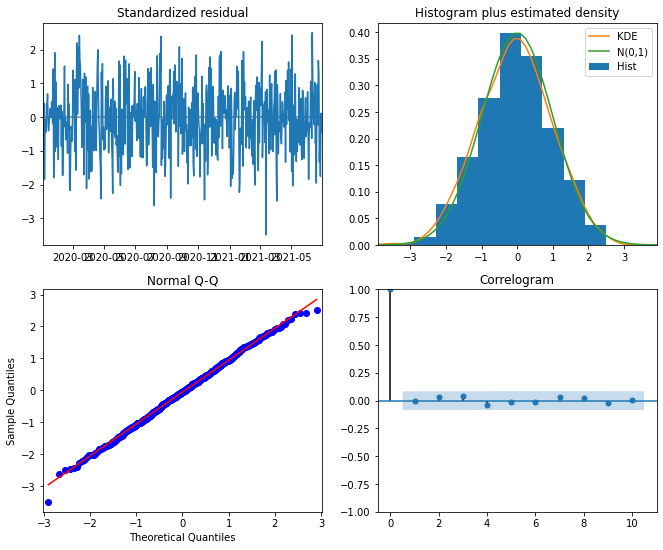

In [24]:
# Create and fit model
model = SARIMAX(telco_stat_train, order=(1,1,1))
results = model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

In [25]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  546
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -363.986
Date:                Sun, 29 May 2022   AIC                            733.972
Time:                        13:46:52   BIC                            746.875
Sample:                    01-02-2020   HQIC                           739.017
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4656      0.037    -12.430      0.000      -0.539      -0.392
ma.L1         -1.0000      0.701     -1.426      0.154      -2.374       0.374
sigma2         0.2197      0.153      1.433      0.1

Prob(Q) and Prob(JB) in the model summary above are important diagnostic p-values.  The null hypothesis for Prob(Q) is that the residuals are uncorrelated.  The null hypothesis for Prob(JB) is tht the residuals are normal.  If either p-value is less than 0.05 these hypothesis can be rejected.  The summary shows that this is, favorably, not the case.

The seasonal component can be added to the model by differencing again over a longer time period and specifying similar parameters.  Instead of (p,d,q) there is an additional set of (P,D,Q,M) to be specified.  M is the seasonal period in days, which is 7.  

In [26]:
telco_stationary_weekly = telco_stationary.diff(30).dropna()

telco_train_weekly = telco_stationary_weekly.loc[:'2021-06-30']
telco_test_weekly = telco_stationary_weekly.loc['2021-07-01':]

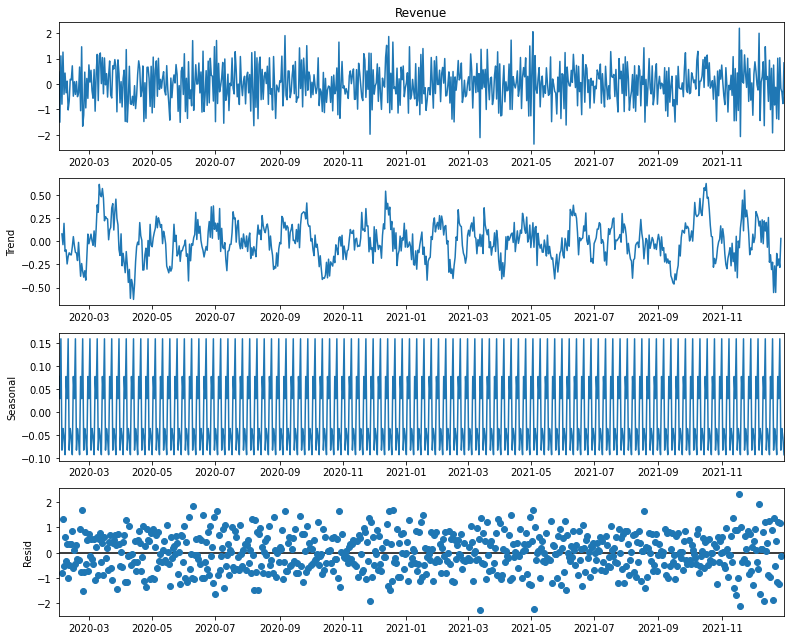

In [27]:
# Perform additive decomposition
decomp_weekly = seasonal_decompose(telco_stationary_weekly['Revenue'], 
                            period=7)

# Plot decomposition
decomp_weekly.plot()
plt.show()

### Final Model Accounting for Seasonality

It may be possible to identify the seasonal SARIMAX parameters by examining properties of ACF and PACF plots as well .  Here ACF and PACF plots over a range of lags as multiples of period are made.  The same logic for p and q can be used, but both are in terms of lags. 

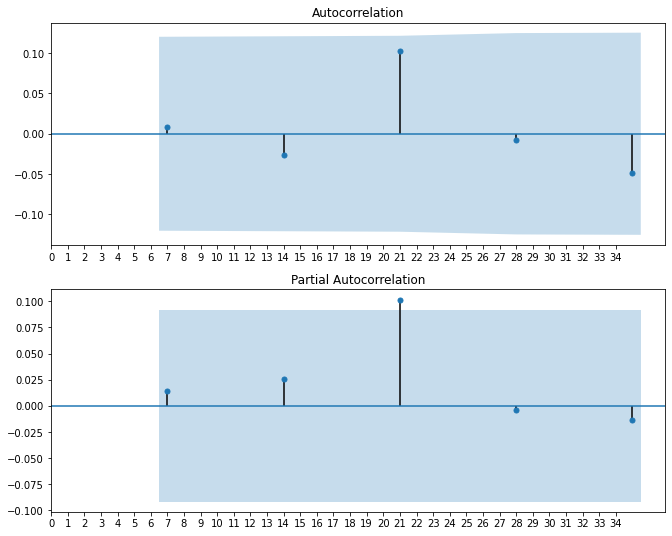

In [27]:
# Make list of lags
lags = [7, 14, 21, 28, 35]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1)

# Plot the ACF on ax1
tsaplots.plot_acf(telco_train_weekly, lags=lags, ax=ax1)
ax1.set_xticks(range(35))
# Plot the PACF on ax2
tsaplots.plot_pacf(telco_train_weekly, lags=lags, ax=ax2)
ax2.set_xticks(range(35))
plt.show()

There doesn't appear to be a clear cutoff or taper in either plot, so it may be better to use a different method of determining P and Q.  The pdarima package has an auto_arima function that iterates over combinations of parameters to find the mininimum AIC.  

In [29]:
import pmdarima as pm

# Create model for SARIMAX(p,1,q)(P,1,Q)7
model3 = pm.auto_arima(telco_train,
                      seasonal=True, m=30,
                      d=1, D=1, 
                      start_p=1, start_q=1,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      information_criterion='aic', 
                      trace=True,
                      error_action='ignore',
                      stepwise=True,
                      suppress_warnings=True) 

# Print model summary
print(model3.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[30]             : AIC=inf, Time=25.04 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=1195.667, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=926.832, Time=1.51 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=14.75 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=1071.183, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=847.529, Time=7.91 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=inf, Time=69.44 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=19.04 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=995.467, Time=4.14 sec
 ARIMA(2,1,0)(2,1,0)[30]             : AIC=849.359, Time=10.00 sec
 ARIMA(1,1,1)(2,1,0)[30]             : AIC=849.405, Time=11.54 sec
 ARIMA(0,1,1)(2,1,0)[30]             : AIC=880.647, Time=8.00 sec
 ARIMA(2,1,1)(2,1,0)[30]             : AIC=850.545, Time=28.44 sec
 ARIMA(1,1,0)(2,1,0)[30] intercept   : AIC=849.109, Time=23.90 sec

Best model:  ARIMA(1,1,0)(2,1,0)[30]  

The auto_arima process produced a model with acceptable Prob(Q) and Prob(JB) metrics.  It is:

SARIMAX(1,1,0)(2,1,0,30).  

The residuals of this model can be examined too.  The characteristics of each plot agree with the good model criteria discussed previously.

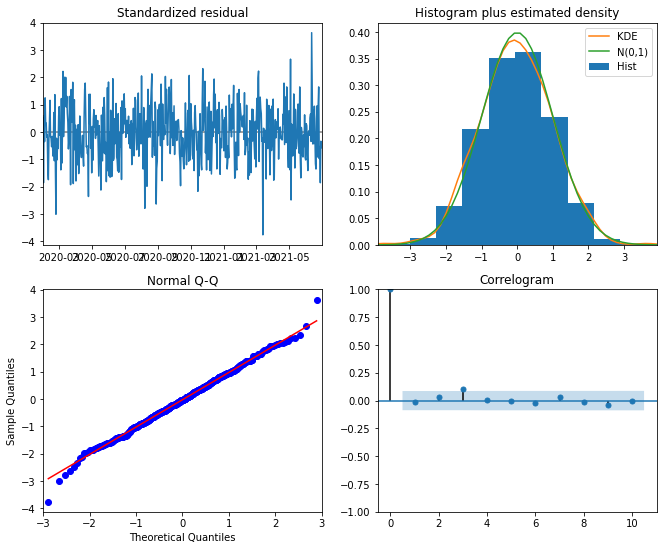

In [30]:
# Create and fit model
smodel = SARIMAX(telco_train, order=(1,1,0), seasonal_order=(2,1,0,30))
sresults = smodel.fit()

# Create the 4 diagostics plots
sresults.plot_diagnostics()
plt.show()

The model that was fitted on the original training data can be used to make a forecast over the range of days in the testing data.  There are 185 days between Jul 1, 2021 and Dec 31, 2021.

In [35]:
diff_forecast = sresults.get_forecast(steps=185)
mean_forecast = diff_forecast.predicted_mean
confidence_intervals = diff_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

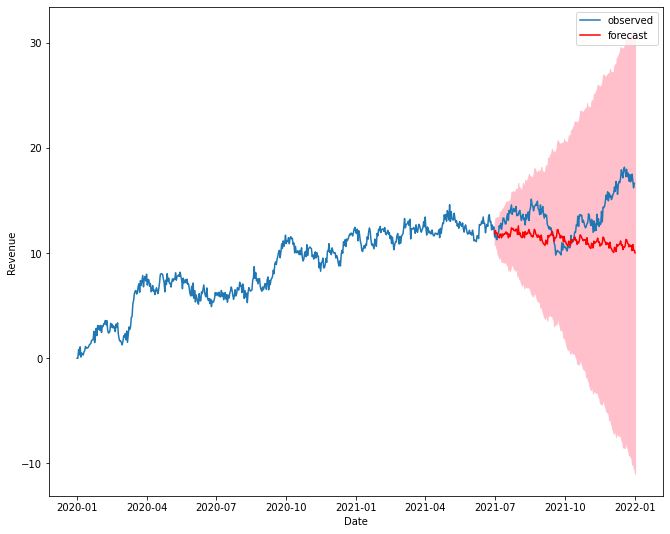

In [36]:
# plot the amazon data
plt.plot(telco2.index, telco2, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [37]:
smodel_test = SARIMAX(telco_test, order=(1,1,0), seasonal_order=(2,1,0,30))
sresults_test = smodel_test.fit()

# Calculate the mean absolute error from residuals
mae_train = np.mean(np.abs(sresults.resid))
mae_test = np.mean(np.abs(sresults_test.resid))

# Print mean absolute error
print("Mean avg. error for training set: ",  mae_train)
print("Mean avg. error for testing set: ",  mae_test)

Mean avg. error for training set:  0.43217493251932154
Mean avg. error for testing set:  0.5426160425770985


The mean average error on training and testing data is about 3% of the range of revenues.

## Summary and Implications

The same SARIMAX model can be fit on the entire data set, then used to make a forecast 90 days into the future.  

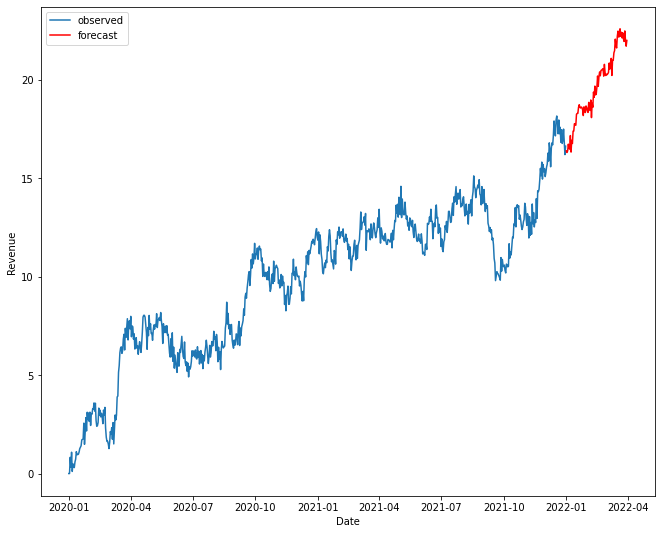

In [41]:
smodel_all = SARIMAX(telco2, order=(1,1,0), seasonal_order=(2,1,0,30))
sresults_all = smodel_all.fit()

diff_forecast_all = sresults_all.get_forecast(steps=90)
mean_forecast_all = diff_forecast_all.predicted_mean
confidence_intervals_all = diff_forecast_all.conf_int()
lower_limits_all = confidence_intervals.loc[:,'lower Revenue']
upper_limits_all = confidence_intervals.loc[:,'upper Revenue']

plt.plot(telco2.index, telco2, label='observed')

plt.plot(mean_forecast_all.index, mean_forecast_all, color='r', label='forecast')

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

The fitted SARIMAX model predicts overall increasing revenues during into the first quarter of the new third year.  There appear to be slight monthly dips, but no long term revenue decrease.

Methods to build up non-seasonal components of an ARIMA model were tried, but the auto_arima process produced some slightly different parameters with no loss in accuracy.  The forecast made from the training data compared to the testing data showed a flat trend in revenue, but the margin of error was wide enough to include the range of actual data during that 6 month period. The same model fit on the entire range of data resulted in a much more exciting forecast that shows predicted revenue climbing at higher rate going into a new quarter.  

The slight monthly dips in revenue predictions may prompt for caution in monthly budgeting, but the overall increase expected over 3 months should allow some leeway to allocate funds for more uses.  Some of these uses may include expanding the network footprint, upgrading existing infrastructure for higher bandwidth capacity, or even providing compensation increases to employees who worked so hard to achieve this increase in profitibility.

### Sources

Rajbhoj, Abhishek. (2019, Sep 26). ARIMA Simplified.  Towards Data Science. https://towardsdatascience.com/arima-simplified-b63315f27cbc

Xiaoyu, Sun. (2018). Understand ARIMA and tune P, D, Q.  Kaggle. https://www.kaggle.com/code/sumi25/understand-arima-and-tune-p-d-q/notebook

Scipy Lecture Notes. (2020). https://scipy-lectures.org/intro/scipy/auto_examples/plot_spectrogram.html

The SciPy community.  (2008-2022).  scipy.signal.welch. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch

PennState.  (2022). STAT 510 | Applied Time Series Analysis.  Section 12.1 Estimating the Spectral Density.  https://online.stat.psu.edu/stat510/lesson/12/12.1

ARIMA Models in Python.  DataCamp.  https://app.datacamp.com/learn/courses/arima-models-in-python